## Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ

In [78]:
import pickle
import numpy as np
import os

import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.util import shuffle_dataset
from common.optimizer import SGD
from common.functions import softmax



In [79]:
import os
import pickle
import numpy as np
from common.util import shuffle_dataset

def load_cifar100(data_dir='./cifar-100-python', validation_rate=0.2):
    def unpickle(file):
        with open(file, 'rb') as fo:
            return pickle.load(fo, encoding='bytes')

    # Load raw data
    train = unpickle(os.path.join(data_dir, 'train'))
    test = unpickle(os.path.join(data_dir, 'test'))

    # Reshape and normalize images
    x_all = train[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    t_all_fine = np.array(train[b'fine_labels'])
    t_all_coarse = np.array(train[b'coarse_labels'])

    # Shuffle before splitting
    #x_all, t_all_fine = shuffle_dataset(x_all, t_all_fine)
    #_, t_all_coarse = shuffle_dataset(x_all, t_all_coarse)  # coarseÎèÑ ÎèôÏùº ÏàúÏÑúÎ°ú ÏÑûÏù¥ÎèÑÎ°ù

    # Validation split
    num_val = int(x_all.shape[0] * validation_rate)

    x_valid = x_all[:num_val]
    t_valid_fine = t_all_fine[:num_val]
    t_valid_coarse = t_all_coarse[:num_val]

    x_train = x_all[num_val:]
    t_train_fine = t_all_fine[num_val:]
    t_train_coarse = t_all_coarse[num_val:]

    # Test set
    x_test = test[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    t_test_fine = np.array(test[b'fine_labels'])
    t_test_coarse = np.array(test[b'coarse_labels'])

    # Mapping dict: fine ‚Üí coarse
    fine_to_coarse = {f: c for f, c in zip(train[b'fine_labels'], train[b'coarse_labels'])}

    return (x_train, t_train_fine, t_train_coarse), \
           (x_valid, t_valid_fine, t_valid_coarse), \
           (x_test, t_test_fine, t_test_coarse), \
           fine_to_coarse


In [80]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Í≤ΩÎ°ú
data_dir = './cifar-100-python'

# Îç∞Ïù¥ÌÑ∞ Î°úÎî© Î∞è Î∂ÑÌï†
(x_train, t_train_fine, t_train_coarse), \
 (x_valid, t_valid_fine, t_valid_coarse), \
 (x_test,  t_test_fine,  t_test_coarse), \
 fine_to_coarse = load_cifar100(data_dir=data_dir)

# ÏòàÏãú Ï∂úÎ†•
print("Fine label ÏòàÏãú (train_fine):", train_fine[:10])
print("Coarse label ÏòàÏãú (train_coarse):", train_coarse[:10])

Fine label ÏòàÏãú (train_fine): [ 8  5 89 94 29 27 61 13 45 79]
Coarse label ÏòàÏãú (train_coarse): [19  3  8  7 10 11  5 19  9  7]


In [81]:
#Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞ ÏÑ§Ï†ï
print("Ï†ÑÏ≤¥ training data Ïàò:", x_train.shape[0])
desired_num=40000
x_train = x_train[:desired_num]
t_train_fine = t_train_fine[:desired_num]
t_train_coarse = t_train_coarse[:desired_num]

Ï†ÑÏ≤¥ training data Ïàò: 40000


In [82]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ÌôïÏù∏
num_train = train_x.shape[0]
num_valid = valid_x.shape[0]
num_test = test_x.shape[0]

# 1. ÏÑûÏùÑ ÏàúÏÑú ÎßåÎì§Í∏∞
shuffle_idx = np.random.permutation(num_train)

# 2. ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º Í∞ôÏùÄ ÏàúÏÑúÎ°ú ÏÑûÍ∏∞
train_x = train_x[shuffle_idx]
train_fine = train_fine[shuffle_idx]
train_coarse = train_coarse[shuffle_idx]

# Í≤ÄÏ¶ù ÎπÑÏú® ÏÑ§Ï†ï
validation_rate = 0.2
validation_num = int(num_train * validation_rate)

# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
valid_x = train_x[:validation_num]
valid_fine = train_fine[:validation_num]
valid_coarse = train_coarse[:validation_num]

# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ïû¨ÏÑ§Ï†ï
train_x = train_x[validation_num:]
train_fine = train_fine[validation_num:]
train_coarse = train_coarse[validation_num:]


In [83]:
# ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Ïù∏Îç±Ïä§ Ï∂îÏ∂ú
num_train = train_x.shape[0]
idx_train = np.arange(num_train)

# Í≤ÄÏ¶ùÏö© Îç∞Ïù¥ÌÑ∞ Ïù∏Îç±Ïä§ Ï∂îÏ∂ú
num_valid = valid_x.shape[0]
idx_valid = np.arange(num_valid)

# ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞ Ïù∏Îç±Ïä§ Ï∂îÏ∂ú
num_test = test_x.shape[0]
idx_test = np.arange(num_test)


## Î™®Îç∏ ÏÑ§Ï†ï

In [150]:
#Ïã†Í≤ΩÎßù ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
input_size = 3072                   # ÏûÖÎ†• Ï∞®Ïõê (32X32X3) #RGB
output_size = 100                   # Ï∂úÎ†• Ï∞®Ïõê (100 ÌÅ¥ÎûòÏä§) #fine label
hideen_size_list = [100, 50]        # ÏùÄÎãâÏ∏µ 2Í∞ú

max_epochs = 1000                     # Epoch ÌöüÏàò
batch_size = 100                    # mini-batch Í∞úÏàò
learning_rate = 0.01                # ÌïôÏäµÎ•†
weight_decay_lambda = 0.01           # Í∞ÄÏ§ëÏπò Í∞êÏÜå Í≥ÑÏàò (Ï†ïÍ∑úÌôî Ìï≠)
activation = 'relu'
weight_init_std = 'he'              # Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî Î∞©Ïãù ('xavier', 'he', 1.0)
use_batchnorm = True                # Î∞∞Ïπò Ï†ïÍ∑úÌôî ÏÇ¨Ïö© Ïó¨Î∂Ä

In [151]:
# --- Îã§Ï∏µ Ïã†Í≤ΩÎßù Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ± ---
# --- MLP---
network = MultiLayerNetExtend(
    input_size=input_size,
    hidden_size_list=hideen_size_list,
    output_size=output_size,
    activation=activation,
    weight_init_std=weight_init_std,
    weight_decay_lambda=weight_decay_lambda,
    use_batchnorm=use_batchnorm
)

In [152]:
# --- ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï ---
optimizer = SGD(lr=learning_rate)
# optimizer = Momentum(lr=learning_rate)
# optimizer = AdaGrad(lr=learning_rate)
# optimizer = Adam(lr=learning_rate)

In [153]:
# --- ÌïôÏäµ Î°úÍ∑∏ Ï†ÄÏû•Ïö© Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî ---
train_loss_list, train_acc_list = [], []
train_loss_per_epoch_list, train_acc_per_epoch_list = [], []

valid_loss_list, valid_acc_list = [], []
valid_loss_per_epoch_list, valid_acc_per_epoch_list = [], []

test_loss_list, test_acc_list = [], []
test_loss_per_epoch_list, test_acc_per_epoch_list = [], []


In [154]:
# --- 1ÏóêÌè≠Îãπ Î∞òÎ≥µ Ïàò Í≥ÑÏÇ∞ ---
train_per_epoch = max(num_train / batch_size, 1)
valid_per_epoch = max(num_valid / batch_size, 1)
test_per_epoch = max(num_test / batch_size, 1)

In [155]:
# --- Î°úÍ∑∏ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Ìï®Ïàò ---
# --- ÎÇòÏ§ëÏóê .py ÌååÏùºÎ°ú Î∫ÑÍ≤É.
import os
import numpy as np

def save_logs_npy(path_prefix='logs/', logs_dict={}):
    os.makedirs(path_prefix, exist_ok=True)
    for name, values in logs_dict.items():
        np.save(os.path.join(path_prefix, f'{name}.npy'), np.array(values))


In [156]:
# Ïòà: Ïã§Ìóò Ïù¥Î¶ÑÎßàÎã§ Î≥ÑÎèÑ Ìè¥ÎçîÎ°ú Î°úÍ∑∏ Ï†ÄÏû•
experiment_name = "mapping_test"
log_path = os.path.join("logs", experiment_name)


save_logs_npy(log_path, {
    'train_loss': train_loss_per_epoch_list,
    'train_acc': train_acc_per_epoch_list,
    'valid_loss': valid_loss_per_epoch_list,
    'valid_acc': valid_acc_per_epoch_list
})

#ÎÇòÏ§ëÏóê Ï†ÄÏû•Îêú ÌååÏùº Î∂àÎü¨Ïò¨ Îïå
#train_loss = np.load('logs/exp1_MLP_mapping/train_loss.npy')


## ÌïôÏäµÎ£®ÌîÑ 

In [157]:
# --- ÌïôÏäµ Î£®ÌîÑ ÏãúÏûë ---
for iepoch in range(max_epochs):
    # Îß§ epochÎßàÎã§ Ïù∏Îç±Ïä§ ÏÖîÌîå (Í∂åÏû•)
    np.random.shuffle(idx_train)
    #np.random.shuffle(idx_valid)

    train_loss = 0
    train_acc = 0
    valid_loss = 0
    valid_acc = 0

    # --- ÌïôÏäµ Îã®Í≥Ñ ---
    for ibatch in range(0, num_train, batch_size):
        batch_mask = idx_train[ibatch:ibatch + batch_size]
        x_batch = train_x[batch_mask]
        y_batch = train_fine[batch_mask]
        # y_batch_coarse = train_coarse[batch_mask]  # coarse labelÎèÑ Ïì∞Í≥† Ïã∂ÏúºÎ©¥ Ïó¨Í∏∞ ÏÇ¨Ïö©

        # ÏÜêÏã§ Î∞è Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
        _train_loss = network.loss(x_batch, y_batch)
        _train_acc = network.accuracy(x_batch, y_batch)
        train_loss += _train_loss
        train_acc += _train_acc

        # Í∏∞Ïö∏Í∏∞ Í≥ÑÏÇ∞ Î∞è ÌååÎùºÎØ∏ÌÑ∞ ÏóÖÎç∞Ïù¥Ìä∏
        grads = network.gradient(x_batch, y_batch)
        optimizer.update(network.params, grads)

        # Î∞∞Ïπò Îã®ÏúÑ Î°úÍ∑∏ Í∏∞Î°ù
        train_loss_list.append(_train_loss)
        train_acc_list.append(_train_acc)

    # ÏóêÌè≠ Îã®ÏúÑ Î°úÍ∑∏ Í∏∞Î°ù
    train_loss_per_epoch_list.append(train_loss / train_per_epoch)
    train_acc_per_epoch_list.append(train_acc / train_per_epoch)

    # --- Í≤ÄÏ¶ù Îã®Í≥Ñ ---
    for ibatch in range(0, num_valid, batch_size):
        batch_mask = idx_valid[ibatch:ibatch + batch_size]
        x_batch = valid_x[batch_mask]
        y_batch = valid_fine[batch_mask]

        _valid_loss = network.loss(x_batch, y_batch)
        _valid_acc = network.accuracy(x_batch, y_batch)
        valid_loss += _valid_loss
        valid_acc += _valid_acc

        valid_loss_list.append(_valid_loss)
        valid_acc_list.append(_valid_acc)

    # ÏóêÌè≠ Îã®ÏúÑ Í≤ÄÏ¶ù Î°úÍ∑∏ Í∏∞Î°ù
    valid_loss_per_epoch_list.append(valid_loss / valid_per_epoch)
    valid_acc_per_epoch_list.append(valid_acc / valid_per_epoch)

    # --- Î°úÍ∑∏ Ï∂úÎ†• ---
    print(f"[epoch] {iepoch} / {max_epochs} | [Train] loss:{train_loss_per_epoch_list[-1]:.4f}, acc:{train_acc_per_epoch_list[-1]:.4f} | [Valid] loss:{valid_loss_per_epoch_list[-1]:.4f}, acc:{valid_acc_per_epoch_list[-1]:.4f}")


[epoch] 0 / 1000 | [Train] loss:7.5796, acc:0.0285 | [Valid] loss:6.9120, acc:0.0425
[epoch] 1 / 1000 | [Train] loss:6.7787, acc:0.0522 | [Valid] loss:6.6882, acc:0.0613
[epoch] 2 / 1000 | [Train] loss:6.5697, acc:0.0701 | [Valid] loss:6.5501, acc:0.0716
[epoch] 3 / 1000 | [Train] loss:6.4057, acc:0.0882 | [Valid] loss:6.4103, acc:0.0843
[epoch] 4 / 1000 | [Train] loss:6.2653, acc:0.1002 | [Valid] loss:6.3002, acc:0.0875
[epoch] 5 / 1000 | [Train] loss:6.1383, acc:0.1095 | [Valid] loss:6.2059, acc:0.0909
[epoch] 6 / 1000 | [Train] loss:6.0231, acc:0.1200 | [Valid] loss:6.1034, acc:0.0958
[epoch] 7 / 1000 | [Train] loss:5.9208, acc:0.1238 | [Valid] loss:6.0227, acc:0.1007
[epoch] 8 / 1000 | [Train] loss:5.8198, acc:0.1311 | [Valid] loss:5.9519, acc:0.1042
[epoch] 9 / 1000 | [Train] loss:5.7243, acc:0.1405 | [Valid] loss:5.8585, acc:0.1142
[epoch] 10 / 1000 | [Train] loss:5.6356, acc:0.1488 | [Valid] loss:5.8050, acc:0.1095
[epoch] 11 / 1000 | [Train] loss:5.5513, acc:0.1519 | [Valid] lo

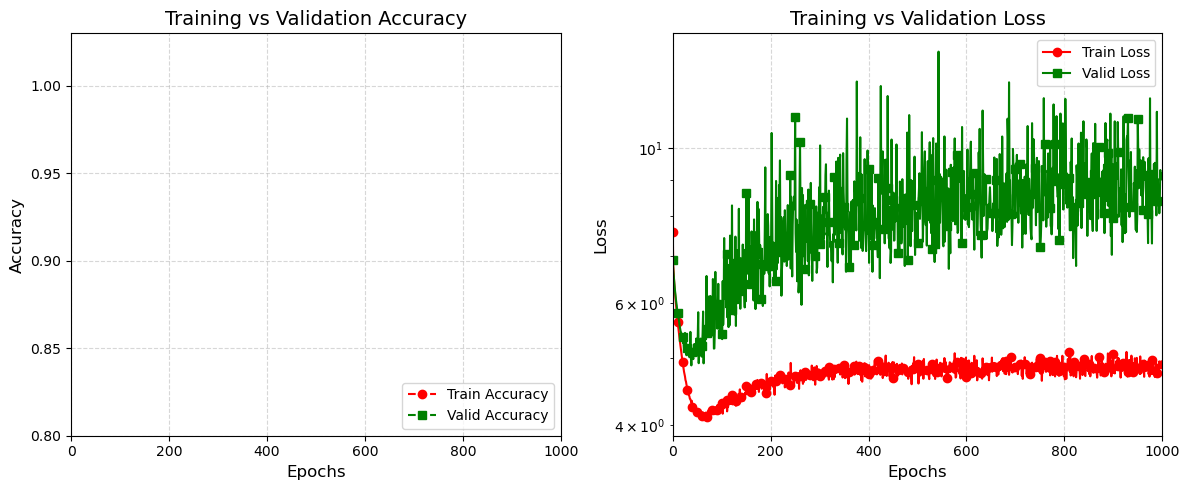

In [166]:
import matplotlib.pyplot as plt

# --- ÎßàÏª§ Ïä§ÌÉÄÏùº Ï†ïÏùò ---
markers = {'train': 'o', 'valid': 's'}

# --- Ï†ÑÏ≤¥ Í∑∏Î¶º ÏÑ§Ï†ï ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1Ìñâ 2Ïó¥

# === [1] Ï†ïÌôïÎèÑ ÏãúÍ∞ÅÌôî (ÏôºÏ™Ω) ===
ax = axs[0]  # ÏôºÏ™Ω subplot
ax.plot(
    train_acc_per_epoch_list,
    'r--',
    marker=markers['train'],
    label='Train Accuracy',
    markevery=10
)
ax.plot(
    valid_acc_per_epoch_list,
    'g--',
    marker=markers['valid'],
    label='Valid Accuracy',
    markevery=10
)

ax.set_title("Training vs Validation Accuracy", fontsize=14)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_ylim(0.8, 1.03)
ax.set_xlim(0, max_epochs)
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)

# === [2] ÏÜêÏã§ ÏãúÍ∞ÅÌôî (Ïò§Î•∏Ï™Ω) ===
ax = axs[1]  # Ïò§Î•∏Ï™Ω subplot
ax.plot(
    train_loss_per_epoch_list,
    'r-',
    marker=markers['train'],
    label='Train Loss',
    markevery=10
)
ax.plot(
    valid_loss_per_epoch_list,
    'g-',
    marker=markers['valid'],
    label='Valid Loss',
    markevery=10
)

ax.set_title("Training vs Validation Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_xlim(0, max_epochs)
ax.set_yscale('log')  # Î°úÍ∑∏ Ïä§ÏºÄÏùº ÏÇ¨Ïö©
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.5)

# --- Î†àÏù¥ÏïÑÏõÉ Ï†ïÎ¶¨ Î∞è Ï∂úÎ†• ---
plt.tight_layout()
plt.show()


## Î°úÍ∑∏ ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•

In [252]:
# fine label ÏòàÏ∏° Í≤∞Í≥º
pred_fine = np.argmax(softmax_output, axis=1)
# fine accuracy Í≥ÑÏÇ∞
fine_acc_total = np.mean(pred_fine == t_valid_coarse)

print(f"Fine-class Top-1 Accuracy: {fine_acc_total:.4f}")

Fine-class Top-1 Accuracy: 0.0113


In [217]:
#Î°úÍ∑∏, ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû•
save_logs_npy(log_path, {
    'train_loss': train_loss_per_epoch_list,
    'train_acc': train_acc_per_epoch_list,
    'valid_loss': valid_loss_per_epoch_list,
    'valid_acc': valid_acc_per_epoch_list
})


save_dir = "logs/mapping_test"   # ÏõêÌïòÎäî Ìè¥Îçî
os.makedirs(save_dir, exist_ok=True)

# network.paramsÎäî {'W1': ..., 'b1': ..., 'W2': ..., ...} ÌòïÌÉú
np.savez(os.path.join(save_dir, "model_params.npz"), **network.params)

print("‚úÖ Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å")

‚úÖ Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å


## Î™®Îç∏ ÌèâÍ∞Ä

In [255]:
# --- ÌÖåÏä§Ìä∏ ÏÜêÏã§ Î∞è Ï†ïÌôïÎèÑ Ï¥àÍ∏∞Ìôî ---
test_loss = 0
test_acc = 0

# --- ÌÖåÏä§Ìä∏ Ïù∏Îç±Ïä§ ÏàúÌöå ---
for ibatch in range(0, num_test, batch_size):
    _ibatch = ibatch + batch_size
    if _ibatch > num_test:
        _ibatch = num_test  # Î≤îÏúÑ Ï¥àÍ≥º Î∞©ÏßÄ

    batch_mask = idx_test[ibatch:_ibatch]
    x_batch = x_test[batch_mask]
    t_batch = t_test_fine[batch_mask]  # fine label Í∏∞Ï§Ä

    # Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º ÌèâÍ∞Ä
    _test_loss = network.loss(x_batch, t_batch)
    _test_acc = network.accuracy(x_batch, t_batch)

    test_loss += _test_loss
    test_acc += _test_acc

    test_loss_list.append(_test_loss)
    test_acc_list.append(_test_acc)

# --- ÌèâÍ∑† ÏÜêÏã§ Î∞è Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ ---
test_loss_per_epoch_list.append(test_loss / test_per_epoch)
test_acc_per_epoch_list.append(test_acc / test_per_epoch)

# --- Í≤∞Í≥º Ï∂úÎ†• ---
print(f"[Test] loss: {test_loss_per_epoch_list[-1]:.4f}, acc: {test_acc_per_epoch_list[-1]:.4f}")


[Test] loss: 9.2874, acc: 0.0640


## Îß§Ìïë Ï†ÑÎã®Í≥Ñ.(valid Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ÏÑú Îß§Ìïë ÌõÑ ÏÑ±Îä• Í≤ÄÏÇ¨)

In [218]:
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ïù¥Ïö©Ìïú ÏòàÏ∏°
y_valid_coarse = network.predict(x_valid)  # ÏïÑÏßÅ softmax ÌÜµÍ≥º Ï†Ñ, logit ÏÉÅÌÉú
print("ÏòàÏ∏° Í≤∞Í≥º (logit)Ïùò shape:", y_valid_coarse.shape)  # Ïòà: (batch_size, num_classes)
print("ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(valid_x)Ïùò shape:", x_valid.shape)

# softmaxÎ•º Ï†ÅÏö©Ìï¥ ÌôïÎ•† Î∂ÑÌè¨Î°ú Î≥ÄÌôò
softmax_output = softmax(y_valid_coarse)  # Í∞Å ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÌôïÎ•† Ï∂úÎ†•

# ÏòàÏãúÎ°ú Ï≤´ ÏÉòÌîåÏùò ÏòàÏ∏° Í≤∞Í≥º Ï∂úÎ†•
#print("Ï≤´ Î≤àÏß∏ ÏÉòÌîåÏùò softmax Í≤∞Í≥º (ÌôïÎ•† Î∂ÑÌè¨):", softmax_output[0])
#print("ÏòàÏ∏°Îêú ÌÅ¥ÎûòÏä§ (argmax):", np.argmax(softmax_output[0]))


ÏòàÏ∏° Í≤∞Í≥º (logit)Ïùò shape: (10000, 100)
ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(valid_x)Ïùò shape: (10000, 3, 32, 32)


## 1.Îã®Ïàú ÎîïÏÖîÎÑàÎ¶¨

In [219]:
import pickle

def load_fine_to_coarse_from_train(data_dir='./cifar-100-python'):
    with open(f"{data_dir}/train", 'rb') as f:
        train_data = pickle.load(f, encoding='bytes')

    fine_labels = train_data[b'fine_labels']
    coarse_labels = train_data[b'coarse_labels']

    fine_to_coarse = {}
    for f, c in zip(fine_labels, coarse_labels):
        if f not in fine_to_coarse:
            fine_to_coarse[f] = c
        else:
            assert fine_to_coarse[f] == c, f"Conflict: {f} ‚Üí {fine_to_coarse[f]} vs {c}"
    
    return fine_to_coarse

In [220]:
# Îß§Ìïë ÌÖåÏù¥Î∏î
def get_cifar100_fine_to_coarse_dict():
    """
    CIFAR-100Ïùò fine label (0~99)ÏùÑ coarse label (0~19)Î°ú Îß§ÌïëÌïòÎäî ÎîïÏÖîÎÑàÎ¶¨Î•º Î∞òÌôò
    """
    fine_to_coarse = {
         0:  0,  1:  0,  2:  0,  3:  0,  4:  0,
         5:  1,  6:  1,  7:  1,  8:  1,  9:  1,
        10:  2, 11:  2, 12:  2, 13:  2, 14:  2,
        15:  3, 16:  3, 17:  3, 18:  3, 19:  3,
        20:  4, 21:  4, 22:  4, 23:  4, 24:  4,
        25:  5, 26:  5, 27:  5, 28:  5, 29:  5,
        30:  6, 31:  6, 32:  6, 33:  6, 34:  6,
        35:  7, 36:  7, 37:  7, 38:  7, 39:  7,
        40:  8, 41:  8, 42:  8, 43:  8, 44:  8,
        45:  9, 46:  9, 47:  9, 48:  9, 49:  9,
        50: 10, 51: 10, 52: 10, 53: 10, 54: 10,
        55: 11, 56: 11, 57: 11, 58: 11, 59: 11,
        60: 12, 61: 12, 62: 12, 63: 12, 64: 12,
        65: 13, 66: 13, 67: 13, 68: 13, 69: 13,
        70: 14, 71: 14, 72: 14, 73: 14, 74: 14,
        75: 15, 76: 15, 77: 15, 78: 15, 79: 15,
        80: 16, 81: 16, 82: 16, 83: 16, 84: 16,
        85: 17, 86: 17, 87: 17, 88: 17, 89: 17,
        90: 18, 91: 18, 92: 18, 93: 18, 94: 18,
        95: 19, 96: 19, 97: 19, 98: 19, 99: 19
    }
    return fine_to_coarse


In [221]:
def map_softmax_to_coarse(softmax_output, fine_to_coarse):
    """
    softmax_output: shape (N, 100), softmax ÌôïÎ•† Í≤∞Í≥º
    fine_to_coarse: dict, fine label ‚Üí coarse label Îß§Ìïë
    
    return: pred_coarse: shape (N,), coarse label ÏòàÏ∏° Í≤∞Í≥º
    """
    fine_pred = np.argmax(softmax_output, axis=1)  # shape (N,)
    coarse_pred = np.array([fine_to_coarse[f] for f in fine_pred])  # shape (N,)
    return coarse_pred

In [222]:
print("Softmax_output.shape",softmax_output.shape)

Softmax_output.shape (10000, 100)


In [223]:
# Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨ Î∂àÎü¨Ïò§Í∏∞
fine_to_coarse = get_cifar100_fine_to_coarse_dict()

# fine label ÏòàÏ∏° ‚Üí coarse label Îß§Ìïë
y_fine = np.argmax(softmax_output, axis=1)
y_coarse = np.array([fine_to_coarse[f] for f in pred_fine])

# Ï†ïÎãµ coarse label Îß§Ìïë
y_coarse_dic = np.array([fine_to_coarse[f] for f in t_valid_fine])  # ÎòêÎäî y_val

# --- ÏòàÏãú Ï∂úÎ†• ---
for a in range(30):
    print(f"[{a}] predict fine label:    {pred_fine[a]}")
    print(f"    true fine label:      {valid_fine[a]}")
    print(f"    predict coarse label: {pred_coarse[a]}")
    print(f"    true coarse label:   {true_coarse[a]}\n")


[0] predict fine label:    92
    true fine label:      16
    predict coarse label: 18
    true coarse label:   3

[1] predict fine label:    92
    true fine label:      36
    predict coarse label: 18
    true coarse label:   7

[2] predict fine label:    5
    true fine label:      64
    predict coarse label: 1
    true coarse label:   12

[3] predict fine label:    84
    true fine label:      53
    predict coarse label: 16
    true coarse label:   10

[4] predict fine label:    1
    true fine label:      73
    predict coarse label: 0
    true coarse label:   14

[5] predict fine label:    5
    true fine label:      48
    predict coarse label: 1
    true coarse label:   9

[6] predict fine label:    1
    true fine label:      53
    predict coarse label: 0
    true coarse label:   10

[7] predict fine label:    5
    true fine label:      26
    predict coarse label: 1
    true coarse label:   5

[8] predict fine label:    92
    true fine label:      7
    predict coarse l

## 2.confidence Í∏∞Î∞ò Îß§Ìïë

In [224]:
import numpy as np

def entropy_based_coarse(softmax_output, fine_to_coarse, num_coarse=20):
    """
    softmax Í≤∞Í≥ºÏùò ÏóîÌä∏Î°úÌîºÎ•º Í∏∞Î∞òÏúºÎ°ú Ïã†Î¢∞ÎèÑÎ•º Ï∂îÏ†ïÌïòÍ≥†,
    coarse-class ÌôïÎ•†Î°ú Î≥ÄÌôòÌïòÎäî ÌõÑÏ≤òÎ¶¨ Ìï®ÏàòÏûÖÎãàÎã§.

    Parameters:
    -----------
    softmax_output : np.ndarray
        shape (N, 100) ‚Äî Î™®Îç∏Ïùò fine-class softmax Ï∂úÎ†•
    fine_to_coarse : dict
        fine-class index (0~99) ‚Üí coarse-class index (0~19) Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨
    num_coarse : int
        coarse ÌÅ¥ÎûòÏä§ Í∞úÏàò (Í∏∞Î≥∏: 20)

    Returns:
    --------
    coarse_probs : np.ndarray
        shape (N, 20) ‚Äî Í∞Å sampleÏùò coarse-class ÌôïÎ•† Î∂ÑÌè¨
    """

    N = softmax_output.shape[0]  # sample Í∞úÏàò
    log100 = np.log(100)         # ÏµúÎåÄ ÏóîÌä∏Î°úÌîº Í∞í (Ï†ïÍ∑úÌôîÏö©)
    coarse_probs = np.zeros((N, num_coarse))  # Í≤∞Í≥º coarse ÌôïÎ•† Ï¥àÍ∏∞Ìôî

    for i in range(N):
        # ‚ë† Ìï¥Îãπ ÏÉòÌîåÏùò softmax Î≤°ÌÑ∞ (fine-class ÌôïÎ•†)
        fine_probs = softmax_output[i]  # shape (100,)

        # ‚ë° entropy Í≥ÑÏÇ∞ (Î∂àÌôïÏã§ÏÑ± Ï∏°Ï†ï)
        entropy = -np.sum(fine_probs * np.log(fine_probs + 1e-9))  # log(0) Î∞©ÏßÄ

        # ‚ë¢ Ïã†Î¢∞ÎèÑ Í≥ÑÏÇ∞: ÌôïÏã†Ïù¥ ÎÜíÏùÑÏàòÎ°ù 1Ïóê Í∞ÄÍπåÏõÄ
        confidence = 1 - (entropy / log100)

        # ‚ë£ fine-class ÌôïÎ•†Ïóê confidence Í≥±ÌïòÍ∏∞ (ÌôïÏã†ÎèÑ Í∏∞Î∞ò Í∞ÄÏ§ë)
        weighted_fine_probs = fine_probs * confidence  # shape (100,)

        # ‚ë§ coarse-class Îã®ÏúÑÎ°ú Ìï©ÏÇ∞
        for fine_idx, prob in enumerate(weighted_fine_probs):
            coarse_idx = fine_to_coarse[fine_idx]
            coarse_probs[i][coarse_idx] += prob

    return coarse_probs  # shape (N, 20)


In [225]:
# coarse softmax Î∂ÑÌè¨ Í≥ÑÏÇ∞
coarse_probs = entropy_based_coarse(softmax_output, fine_to_coarse)

# coarse ÏòàÏ∏° (argmax)
y_fine = np.argmax(softmax_output, axis=1)
y_coarse = np.argmax(coarse_probs, axis=1)

# Ï†ïÎãµ coarse label
y_coarse_confi = np.array([fine_to_coarse[f] for f in valid_fine])

# --- ÏòàÏãú Ï∂úÎ†• ---
for a in range(30):
    print(f"[{a}] predict fine label:    {pred_fine[a]}")
    print(f"    true fine label:      {valid_fine[a]}")
    print(f"    predict coarse label: {pred_coarse[a]}")
    print(f"    true coarse label:   {y_coarse_confi[a]}\n")

[0] predict fine label:    92
    true fine label:      16
    predict coarse label: 18
    true coarse label:   3

[1] predict fine label:    92
    true fine label:      36
    predict coarse label: 18
    true coarse label:   7

[2] predict fine label:    5
    true fine label:      64
    predict coarse label: 1
    true coarse label:   12

[3] predict fine label:    84
    true fine label:      53
    predict coarse label: 16
    true coarse label:   10

[4] predict fine label:    1
    true fine label:      73
    predict coarse label: 0
    true coarse label:   14

[5] predict fine label:    5
    true fine label:      48
    predict coarse label: 1
    true coarse label:   9

[6] predict fine label:    1
    true fine label:      53
    predict coarse label: 0
    true coarse label:   10

[7] predict fine label:    5
    true fine label:      26
    predict coarse label: 1
    true coarse label:   5

[8] predict fine label:    92
    true fine label:      7
    predict coarse l

## 3.soft label Í∏∞Î∞ò coarse Îß§Ìïë

In [226]:
def softlabel_coarse_mapping(fine_probs, fine_to_coarse_dict, num_coarse=20):
    batch_size = fine_probs.shape[0]
    coarse_probs = np.zeros((batch_size, num_coarse))

    for fine_idx in range(100):
        coarse_idx = fine_to_coarse_dict[fine_idx]
        coarse_probs[:, coarse_idx] += fine_probs[:, fine_idx]
    
    return coarse_probs


In [227]:
fine_to_coarse_arr = np.array([fine_to_coarse[i] for i in range(100)])

# soft-label coarse Î∂ÑÌè¨ Í≥ÑÏÇ∞
coarse_probs_softlabel = softlabel_coarse_mapping(softmax_output, fine_to_coarse_arr)

# coarse ÏòàÏ∏°
y_coarse_softlabel = np.argmax(coarse_probs_softlabel, axis=1)
true_coarse = np.array([fine_to_coarse[f] for f in valid_fine])

# --- ÏòàÏãú Ï∂úÎ†• ---
for a in range(30):
    print(f"[{a}] predict fine label:    {pred_fine[a]}")
    print(f"    true fine label:      {valid_fine[a]}")
    print(f"    predict coarse label: {pred_coarse[a]}")
    print(f"    true coarse label:   {true_coarse[a]}\n")

[0] predict fine label:    92
    true fine label:      16
    predict coarse label: 18
    true coarse label:   3

[1] predict fine label:    92
    true fine label:      36
    predict coarse label: 18
    true coarse label:   7

[2] predict fine label:    5
    true fine label:      64
    predict coarse label: 1
    true coarse label:   12

[3] predict fine label:    84
    true fine label:      53
    predict coarse label: 16
    true coarse label:   10

[4] predict fine label:    1
    true fine label:      73
    predict coarse label: 0
    true coarse label:   14

[5] predict fine label:    5
    true fine label:      48
    predict coarse label: 1
    true coarse label:   9

[6] predict fine label:    1
    true fine label:      53
    predict coarse label: 0
    true coarse label:   10

[7] predict fine label:    5
    true fine label:      26
    predict coarse label: 1
    true coarse label:   5

[8] predict fine label:    92
    true fine label:      7
    predict coarse l

## 4. Validation-guided fine class weighting for coarse mapping

In [228]:
#Step 1. fine-classÎ≥Ñ validation Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ ‚Üí fine_weight[100]
#Step 2. softmax_output √ó fine_weight ‚Üí weighted_softmax
#Step 3. fine ‚Üí coarse Í∑∏Î£π Ìï©ÏÇ∞ ‚Üí coarse_probs_weighted
#Step 4. argmax(coarse_probs_weighted) ‚Üí coarse ÏòàÏ∏°

In [229]:
def compute_fine_class_accuracy(pred_fine, true_fine, num_classes=100):
    correct = np.zeros(num_classes)
    total = np.zeros(num_classes)

    for pf, tf in zip(pred_fine, true_fine):
        total[tf] += 1
        if pf == tf:
            correct[tf] += 1

    acc = correct / (total + 1e-9)  # avoid divide by 0
    acc = acc / np.max(acc)        # normalize to [0, 1]
    return acc  # shape (100,)


In [230]:
def validation_weighted_coarse(softmax_output, fine_weight, fine_to_coarse, num_coarse=20):
    weighted_fine = softmax_output * fine_weight[np.newaxis, :]  # shape (N, 100)
    coarse_probs = np.zeros((softmax_output.shape[0], num_coarse))
    
    for f in range(100):
        c = fine_to_coarse[f]
        coarse_probs[:, c] += weighted_fine[:, f]
    
    return coarse_probs  # shape (N, 20)


In [243]:
# 1. fine accuracy Í∏∞Î∞ò weight Íµ¨ÌïòÍ∏∞
fine_acc = compute_fine_class_accuracy(pred_fine_argmax, valid_fine)
# 2. Í∞ÄÏ§ë coarse ÌôïÎ•† Î∂ÑÌè¨ ÎßåÎì§Í∏∞
coarse_probs_val_weight = validation_weighted_coarse(softmax_output, fine_acc, fine_to_coarse)
# 3. ÏòàÏ∏°
pred_coarse_val_weight = np.argmax(coarse_probs_val_weight, axis=1)

# --- ÏòàÏãú Ï∂úÎ†• ---
for a in range(30):
    print(f"[{a}] predict fine label:    {pred_fine[a]}")
    print(f"    true fine label:      {valid_fine[a]}")
    print(f"    predict coarse label: {pred_coarse_val_weight[a]}")
    print(f"    true coarse label:   {true_coarse[a]}\n")

[0] predict fine label:    92
    true fine label:      16
    predict coarse label: 9
    true coarse label:   3

[1] predict fine label:    92
    true fine label:      36
    predict coarse label: 9
    true coarse label:   7

[2] predict fine label:    5
    true fine label:      64
    predict coarse label: 2
    true coarse label:   12

[3] predict fine label:    84
    true fine label:      53
    predict coarse label: 2
    true coarse label:   10

[4] predict fine label:    1
    true fine label:      73
    predict coarse label: 9
    true coarse label:   14

[5] predict fine label:    5
    true fine label:      48
    predict coarse label: 2
    true coarse label:   9

[6] predict fine label:    1
    true fine label:      53
    predict coarse label: 13
    true coarse label:   10

[7] predict fine label:    5
    true fine label:      26
    predict coarse label: 9
    true coarse label:   5

[8] predict fine label:    92
    true fine label:      7
    predict coarse lab

## Îß§Ìïë Í∏∞Î≤ïÎ≥Ñ ÏÑ±Îä•(Ï†ïÌôïÎèÑ)

In [247]:
print("softmax_output.shape:", softmax_output.shape)  
print("valid_fine.shape:", valid_fine.shape)          

softmax_output.shape: (10000, 100)
valid_fine.shape: (4096,)


In [248]:
#softmax_output todtjd
logits = network.predict(x_valid)
softmax_output = softmax(logits)

# Í≥µÌÜµ Ï†ïÎãµ coarse label
true_coarse = np.array([fine_to_coarse[f] for f in valid_fine])



# valid indexÎßå Ï∂îÎ†§ÏÑú softmax Ï∂úÎ†•ÎèÑ Ï§ÑÏù¥Í∏∞
valid_idx = np.arange(len(valid_fine))  # valid indexÍ∞Ä Îî∞Î°ú ÏûàÎã§Î©¥ Í∑∏Í±∏ Ïç®Ïïº Ìï®
softmax_valid = softmax_output[valid_idx]

# 1. Argmax Í∏∞Î∞ò coarse ÏòàÏ∏°
pred_fine_argmax = np.argmax(softmax_valid, axis=1)
pred_coarse_argmax = np.array([fine_to_coarse[f] for f in pred_fine_argmax])
acc_argmax = np.mean(pred_coarse_argmax == true_coarse)

# 2. Entropy Í∏∞Î∞ò
coarse_probs_entropy = entropy_based_coarse(softmax_valid, fine_to_coarse)
pred_coarse_entropy = np.argmax(coarse_probs_entropy, axis=1)
acc_entropy = np.mean(pred_coarse_entropy == true_coarse)

# 3. Soft-label ÌèâÍ∑†
coarse_probs_softlabel = softlabel_coarse_mapping(softmax_valid, fine_to_coarse_arr)
pred_coarse_softlabel = np.argmax(coarse_probs_softlabel, axis=1)
acc_softlabel = np.mean(pred_coarse_softlabel == true_coarse)

# 4. Validation accuracy Í∏∞Î∞ò coarse ÏòàÏ∏°
fine_acc = compute_fine_class_accuracy(pred_fine_argmax, valid_fine)  # (100,)
coarse_probs_val_weight = validation_weighted_coarse(softmax_valid, fine_acc, fine_to_coarse)
pred_coarse_val_weight = np.argmax(coarse_probs_val_weight, axis=1)
acc_val_weight = np.mean(pred_coarse_val_weight == true_coarse)


### ÏÑ±Îä• Ï∂úÎ†•
print("Coarse Accuracy ÎπÑÍµê")
print(f"1. Argmax Í∏∞Î∞ò         : {acc_argmax:.4f}")
print(f"2. Entropy-weighted    : {acc_entropy:.5f}")
print(f"3. Soft-label ÌèâÍ∑† Í∏∞Î∞ò: {acc_softlabel:.5f}")
print(f"4. Validation-weight Í∏∞Î∞ò: {acc_val_weight:.4f}")


Coarse Accuracy ÎπÑÍµê
1. Argmax Í∏∞Î∞ò         : 0.0579
2. Entropy-weighted    : 0.05762
3. Soft-label ÌèâÍ∑† Í∏∞Î∞ò: 0.05762
4. Validation-weight Í∏∞Î∞ò: 0.0564


## Îß§Ìïë Í∏∞Î≤ïÎ≥Ñ ÏÑ±Îä•(confusion matrix)

In [239]:
import numpy as np

def hierarchical_confusion_matrix(pred_fine, true_fine, fine_to_coarse, num_coarse=20):
    """
    fine label ÏòàÏ∏° Í≤∞Í≥ºÎ•º coarse labelÎ°ú Îß§ÌïëÌï¥ confusion matrix ÏÉùÏÑ±.

    Parameters:
        pred_fine: np.ndarray (N,) - ÏòàÏ∏° fine label
        true_fine: np.ndarray (N,) - Ï†ïÎãµ fine label
        fine_to_coarse: dict[int ‚Üí int] - fine ‚Üí coarse Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨
        num_coarse: coarse ÌÅ¥ÎûòÏä§ Í∞úÏàò (default 20)

    Returns:
        np.ndarray (num_coarse x num_coarse) - ÌòºÎèô ÌñâÎ†¨
    """
    matrix = np.zeros((num_coarse, num_coarse), dtype=int)
    for pf, tf in zip(pred_fine, true_fine):
        pred_coarse = fine_to_coarse[pf]
        true_coarse = fine_to_coarse[tf]
        matrix[true_coarse][pred_coarse] += 1
    return matrix


In [162]:
print("Confusion Matrix - Argmax Í∏∞Î∞ò coarse ÏòàÏ∏°")
cm_argmax = hierarchical_confusion_matrix(pred_fine_argmax, valid_fine, fine_to_coarse)
print(cm_argmax)

print("\nConfusion Matrix - Entropy-weighted coarse ÏòàÏ∏°")
pred_fine_entropy = np.argmax(softmax_output, axis=1)  # entropy Î∞©ÏãùÏùÄ fineÎèÑ ÎèôÏùº
cm_entropy = hierarchical_confusion_matrix(pred_fine_entropy, valid_fine, fine_to_coarse)
print(cm_entropy)

print("\nConfusion Matrix - Soft-label ÌèâÍ∑† coarse ÏòàÏ∏°")
pred_fine_softlabel = np.argmax(softmax_output, axis=1)  # soft-labelÎèÑ fineÏùÄ ÎèôÏùº
cm_softlabel = hierarchical_confusion_matrix(pred_fine_softlabel, valid_fine, fine_to_coarse)
print(cm_softlabel)


üìå Confusion Matrix - Argmax Í∏∞Î∞ò coarse ÏòàÏ∏°
[[14 35  6 42  4  3  6  9  4  4 11  5  9  0  1  7  3  1 27  3]
 [10 33  6 31  6  1  4  3  3  6  6 10  9  1  5 12  3  3 23  1]
 [ 8 30  5 43  8  2  7  6  7  4  7 18  9  0  5 10  4  2 22  3]
 [15 42  6 51  6  4  2  5  2  6  7 12  9  1  7 11  7  0 17  4]
 [13 39  6 40  6  5  5  6  3  7  7  9 10  0  5 10  5  0 22  2]
 [11 34  4 38  4  5  7  4  4  6  8 13 17  0  7  9  2  0 29  2]
 [16 37  5 38  4  4  3  5  5  9  5 11 12  1  6 11  5  3 18  3]
 [15 46  4 37  4  3  4  9  3  5  7  8 17  4  7 14  5  4 21  4]
 [13 43  4 48  4  2  2  2  5  6 13 10 14  1  3 13  3  3 29  0]
 [16 41  3 44  7  4  6  4  7  6 13  9 12  0  4  4  0  3 15  4]
 [16 30  2 39  7  6  3  5 10  8 16 10 12  1  1 10  3  3 27  4]
 [22 29  5 43  4  4  5  6  4  5 14  9 11  1  4  8  5  0 24  1]
 [11 44  4 32  7  2  5  3  5  4 11 14  8  0  4  9  1  1 26  4]
 [17 31  6 27  7  5  4 13  5 10  8 13 13  0  6 14  3  3 26  3]
 [19 49  5 43  2  1  6  5  2  9 10 10  8  0  3  7  2  3 21  1]
 [ 

## Îß§Ìïë Í∏∞Î≤ïÎ≥Ñ ÏÑ±Îä•(coarse Histogram)


üìä Histogram of Coarse Confidence - Entropy-weighted Î∞©Ïãù


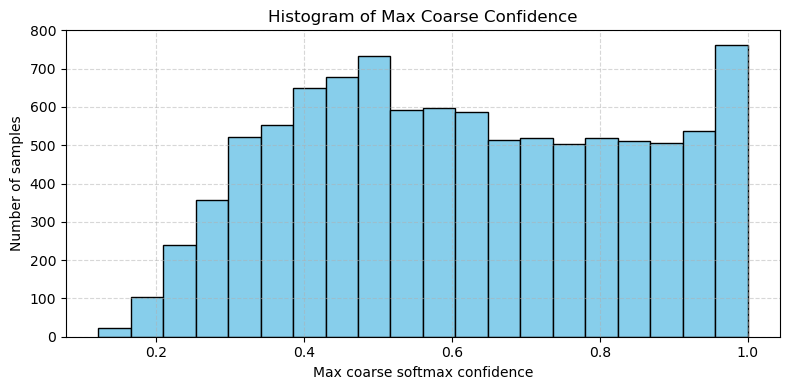


üìä Histogram of Coarse Confidence - Soft-label ÌèâÍ∑† Î∞©Ïãù


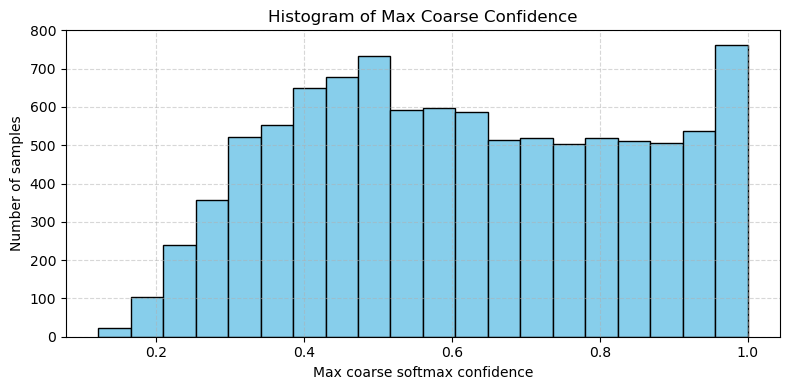